In [141]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [142]:
df = pd.read_csv('./dataset/final_dataset', index_col=0)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
modal_beans,4048.0,2506.765069,1655.048300,600.000000,1400.000000,1900.000000,3300.000000,13000.000000
min_beans,4048.0,2201.438982,1489.531925,400.000000,1200.000000,1600.000000,2900.000000,12000.000000
max_beans,4048.0,2803.893281,1848.667702,700.000000,1600.000000,2000.000000,3600.000000,14000.000000
Arrivals_beans,4048.0,11.502841,6.015456,1.000000,7.500000,11.000000,14.000000,100.000000
modal_ragi,4048.0,2069.420331,795.945640,810.000000,1200.000000,2050.000000,2900.000000,3900.000000
min_ragi,4048.0,1935.111413,765.771109,750.000000,1100.000000,1900.000000,2762.500000,3800.000000
max_ragi,4048.0,2215.898839,820.719479,860.000000,1300.000000,2200.000000,3000.000000,4000.000000
Arrivals_ragi,4048.0,268.317811,290.482019,0.000000,145.000000,231.000000,336.250000,13062.000000
modal_brinjal,4048.0,1308.894516,710.172688,260.000000,800.000000,1100.000000,1650.000000,6000.000000
min_brinjal,4048.0,1135.809536,647.141413,12.000000,700.000000,1000.000000,1500.000000,5000.000000


In [143]:
wv = df.pop('windspeedKmph')
wd_rad = df.pop('winddirDegree')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

(-19.869618668441802,
 17.311547049232427,
 -34.31033490877984,
 19.614224304549023)

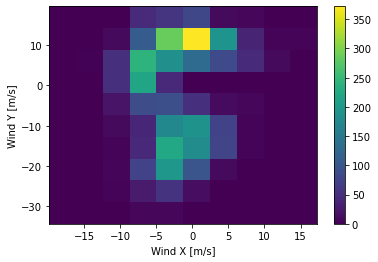

In [144]:
plt.hist2d(df['Wx'], df['Wy'])
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [145]:
df.index = pd.to_datetime(df.index, format='%Y.%m.%d %H:%M:%S')
timestamp_s = df.index.map(pd.Timestamp.timestamp)
day = 24*60*60
# day = 1
month = 12*day
year = (365.2425)*day

df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

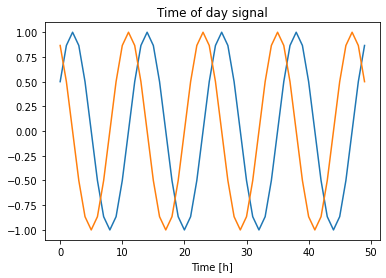

In [146]:
plt.plot(np.array(df['Month sin'][:50]))
plt.plot(np.array(df['Month cos'][:50]))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [147]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [148]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [149]:
train_std.to_csv('./dataset/std')
train_mean.to_csv('./dataset/mean')

In [150]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [151]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [152]:
def plot(self, model=None, plot_col='modal_beans', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [153]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [154]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [155]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [156]:
label_columns = ['modal_beans', 'min_beans', 'max_beans','modal_ragi',
       'min_ragi', 'max_ragi','modal_brinjal', 'min_brinjal',
       'max_brinjal', 'Arrivals_beans', 'Arrivals_brinjal', 'Arrivals_ragi']
num_features = df.shape[1]
label_columns_index = []
for label in label_columns:
    label_columns_index.append(column_indices[label])

In [157]:
wide_step_multi_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=label_columns)


In [158]:
wide_step_multi_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['modal_beans', 'min_beans', 'max_beans', 'modal_ragi', 'min_ragi', 'max_ragi', 'modal_brinjal', 'min_brinjal', 'max_brinjal', 'Arrivals_beans', 'Arrivals_brinjal', 'Arrivals_ragi']

In [159]:
multi_val_performance = {}
multi_test_performance = {}

In [160]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dense(units=32, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(label_columns))
])


In [161]:
lstm_model.layers

In [162]:
history = compile_and_fit(lstm_model, wide_step_multi_window)
multi_val_performance['LSTM'] = lstm_model.evaluate(wide_step_multi_window.val)
multi_test_performance['LSTM'] = lstm_model.evaluate(wide_step_multi_window.test, verbose=0)

Epoch 1/40
89/89 [==============================] - 4s 17ms/step - loss: 0.8298 - mean_absolute_error: 0.6558 - val_loss: 2.4767 - val_mean_absolute_error: 1.1851
Epoch 2/40
89/89 [==============================] - 1s 12ms/step - loss: 0.5209 - mean_absolute_error: 0.4666 - val_loss: 1.7087 - val_mean_absolute_error: 0.9820
Epoch 3/40
89/89 [==============================] - 1s 12ms/step - loss: 0.4267 - mean_absolute_error: 0.3982 - val_loss: 1.4204 - val_mean_absolute_error: 0.8830
Epoch 4/40
89/89 [==============================] - 1s 12ms/step - loss: 0.3764 - mean_absolute_error: 0.3599 - val_loss: 1.2581 - val_mean_absolute_error: 0.8245
Epoch 5/40
89/89 [==============================] - 1s 12ms/step - loss: 0.3438 - mean_absolute_error: 0.3337 - val_loss: 1.1530 - val_mean_absolute_error: 0.7852
Epoch 6/40
89/89 [==============================] - 1s 12ms/step - loss: 0.3208 - mean_absolute_error: 0.3141 - val_loss: 1.0790 - val_mean_absolute_error: 0.7565
Epoch 7/40
89/89 [====

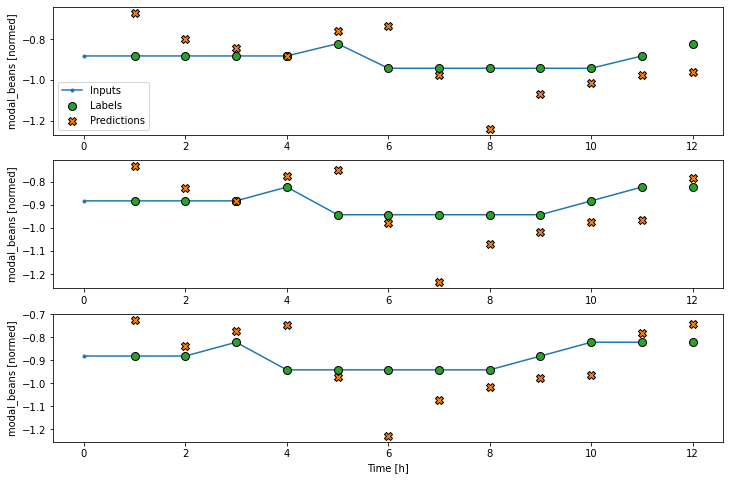

In [163]:
# multi_window.plot(multi_lstm_model)
wide_step_multi_window.plot(lstm_model, plot_col='modal_beans')

In [164]:
CONV_WIDTH = 3
LABEL_WIDTH = 6
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 9
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [3 4 5 6 7 8]
Label column name(s): ['modal_beans', 'min_beans', 'max_beans', 'modal_ragi', 'min_ragi', 'max_ragi', 'modal_brinjal', 'min_brinjal', 'max_brinjal', 'Arrivals_beans', 'Arrivals_brinjal', 'Arrivals_ragi']


conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=len(label_columns)),
])

hist = compile_and_fit(conv_model, wide_conv_window)
multi_val_performance['CONV'] = conv_model.evaluate(wide_conv_window.val)
multi_test_performance['CONV'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

wide_conv_window.plot(conv_model)

In [168]:
CONV_WIDTH = 30
OUT_STEPS=len(label_columns)
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

In [169]:

# multi_conv_model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
#     tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#     # Shape => [batch, 1, conv_units]
#     tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
#     # Shape => [batch, 1,  out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                           kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)
multi_val_performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/40
88/88 [==============================] - 6s 21ms/step - loss: 0.9079 - mean_absolute_error: 0.7441 - val_loss: 1.9599 - val_mean_absolute_error: 1.0343
Epoch 2/40
88/88 [==============================] - 2s 17ms/step - loss: 0.6819 - mean_absolute_error: 0.6088 - val_loss: 1.5160 - val_mean_absolute_error: 0.9021
Epoch 3/40
88/88 [==============================] - 1s 16ms/step - loss: 0.5634 - mean_absolute_error: 0.5307 - val_loss: 1.3332 - val_mean_absolute_error: 0.8393
Epoch 4/40
88/88 [==============================] - 1s 16ms/step - loss: 0.5150 - mean_absolute_error: 0.4939 - val_loss: 1.2440 - val_mean_absolute_error: 0.8142
Epoch 5/40
88/88 [==============================] - 1s 16ms/step - loss: 0.4846 - mean_absolute_error: 0.4747 - val_loss: 1.1800 - val_mean_absolute_error: 0.7960
Epoch 6/40
88/88 [==============================] - 1s 17ms/step - loss: 0.4522 - mean_absolute_error: 0.4548 - val_loss: 1.1088 - val_mean_absolute_error: 0.7700
Epoch 7/40
88/88 [====

In [125]:
multi_lstm_model.input

<KerasTensor: shape=(None, 24, 26) dtype=float32 (created by layer 'lstm_13_input')>

In [170]:
trainDf1 = pd.read_csv('./dataset/final_dataset', index_col=0)
trainDf1.index = pd.to_datetime(trainDf1.index, format='%Y.%m.%d %H:%M:%S')
timestamp_s = trainDf1.index.map(pd.Timestamp.timestamp)
day = 24*60*60
# day = 1
month = 12*day
year = (365.2425)*day

trainDf1['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
trainDf1['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
trainDf1['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
trainDf1['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

wv = trainDf1.pop('windspeedKmph')
wd_rad = trainDf1.pop('winddirDegree')*np.pi / 180

# Calculate the wind x and y components.
trainDf1['Wx'] = wv*np.cos(wd_rad)
trainDf1['Wy'] = wv*np.sin(wd_rad)

trainDf1 = (trainDf1 - train_mean) / train_std
ip = np.array(trainDf1[trainDf1.shape[0]-12:])
ip = np.expand_dims(ip, axis = 0)

pred = multi_lstm_model.predict(ip)
# ip.shape


In [171]:
pred

array([[[-3.71975228e-02, -7.05301911e-02, -1.01940893e-02,
          7.51091361e-01,  8.00484568e-02,  1.09191686e-01,
          1.83052197e-01, -4.09153968e-01, -1.17982309e-02,
         -4.28289585e-02,  2.37141568e-02,  6.70216978e-01,
         -6.09202385e-01, -2.34489925e-02,  3.55170071e-01,
          1.13698438e-01,  3.37542862e-01, -4.44347113e-02,
          1.33280247e-01,  9.14903805e-02,  3.64886731e-01,
          3.76287431e-01, -5.85669279e-01, -2.30991912e+00,
         -6.81786835e-01,  2.79917717e-01],
        [-2.18345895e-02, -5.06318435e-02,  3.16813216e-03,
          6.89503551e-01,  7.77530968e-02,  1.03150561e-01,
          1.87945127e-01, -3.75307113e-01, -9.13124345e-03,
         -4.04168554e-02,  2.31554378e-02,  6.22860432e-01,
         -5.99857867e-01, -5.07930294e-02,  2.89321929e-01,
          6.76761419e-02,  2.94739336e-01, -7.64467418e-02,
          8.11887830e-02,  6.74532279e-02,  3.90212655e-01,
          3.60913962e-01, -1.66708767e+00, -1.75105464e+

In [172]:
lstm_model.save('./model/price_lstm1')
multi_lstm_model.save('./model/price_multi_lstm')
conv_model.save('./model/price_conv')

INFO:tensorflow:Assets written to: ./model/price_lstm1/assets


INFO:tensorflow:Assets written to: ./model/price_lstm1/assets


INFO:tensorflow:Assets written to: ./model/price_multi_lstm/assets


INFO:tensorflow:Assets written to: ./model/price_multi_lstm/assets


INFO:tensorflow:Assets written to: ./model/price_conv/assets


INFO:tensorflow:Assets written to: ./model/price_conv/assets


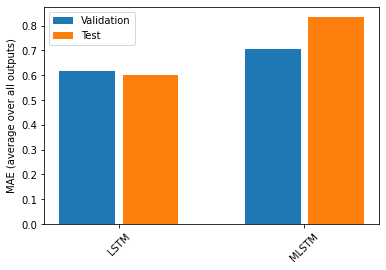

In [173]:
# multi_val_performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_test_performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [184]:
for i in df.modal_brinjal[df.shape[0]-10:]:
    print(i)

3100.0
3000.0
3500.0
3500.0
3500.0
3600.0
3600.0
3600.0
3000.0
3400.0


In [195]:
df.index.max().strftime("%Y-%m-%d")

'2020-01-31'